In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import pickle

# DQN Network

In [7]:
class DQN(nn.Module):
    def __init__(self, input_dimensions, output_dimensions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dimensions, 256)          # Layer to input to 256
        self.fc2 = nn.Linear(256, 128)                        #256 to 128
        self.fc3 = nn.Linear(128, 64)                         # 128 to 64
        self.output = nn.Linear(64, output_dimensions)        # 64 to output

    def forward(self, x):
        x = torch.relu(self.fc1(x))                           # Apply activation function for layer 1
        x = torch.relu(self.fc2(x))                           # Apply activation function for layer 2
        x = torch.relu(self.fc3(x))                           # Apply activation function for layer 3
        return self.output(x)


# Reply Buffer

In [8]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size                                   #No. of actions
        self.memory = deque(maxlen=buffer_size)                          #Memory buffer
        self.batch_size = batch_size                                     #Batch size for
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])                     #Store the experiences for buffer
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        ex = self.experience(state, action, reward, next_state, done)                                     # Append to the experience
        self.memory.append(ex)                                                                           # Append to the memory

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)                                        # Randomly selects the experiece
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                                                      # Use cuda GPU tensor computations

        # Convert each batch of experiences to PyTorch tensors and move them to GPU
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)                                       # length of the memory


# DQN Agent

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size                                  #initilize the state_size
        self.action_size = action_size                                #Initilize the action size
        self.seed = random.seed(seed)                                 #Initilize the seed for random generator
        self.lr = lr                                                  #Initilize the learning rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                  #cuda for the cpu utilization

        self.local_qnet = DQN(state_size, action_size).to(self.device)              # Local Qnet for training
        self.target_qnet = DQN(state_size, action_size).to(self.device)              # Target q net for stabilizing training
        self.optimizer = optim.Adam(self.local_qnet.parameters(), self.lr)                          # Optimizers to apply on the local qnetwork

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)               # Reply buffer initilization
        self.time_step = 0

    def save_model(self, filename='dqn_model.pkl'):
        model_states = {
            'local_qnet_state_dict': self.local_qnet.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'time_step': self.time_step
        }                                                                   # saving the state of model by local qnet, target qnet
        with open(filename, 'wb') as f:
            pickle.dump(model_states, f)
        print(f"Model saved to {filename}")

    def load_model(self, filename='dqn_model.pkl'):
        with open(filename, 'rb') as f:
            model_states = pickle.load(f)
        self.local_qnet.load_state_dict(model_states['local_qnet_state_dict'])
        self.optimizer.load_state_dict(model_states['optimizer_state_dict'])
        self.time_step = model_states['time_step']
        print(f"Model loaded from {filename}")

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)                                              # Append to memory

        self.time_step = (self.time_step + 1) % 4                                                            # Update the time step resetting for every 4 steps

        if self.time_step == 0:                       # perform loading and learning every four steps
            if len(self.memory) > 64:                   # check the experiences
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)
    def act(self, state, eps=0.):
        if isinstance(state, tuple):
          state = state[0]  # Extract the actual state if it's wrapped in a tuple
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)           # Load the state as tensor

        self.local_qnet.eval()                                               # Evaluate the qnet
        with torch.no_grad():                                                # Disable gradient calculation
            action_values = self.local_qnet(state_tensor)                   # Get the action from Q net
        self.local_qnet.train()                                              # Enable gradient calculation for training

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)
    def learn(self, experiences, gamma=0.99):

          states = [e.state for e in experiences if e is not None]
          actions = [e.action for e in experiences if e is not None]
          rewards = [e.reward for e in experiences if e is not None]
          next_states = [e.next_state for e in experiences if e is not None]
          dones = [e.done for e in experiences if e is not None]

          #Convert the each unpacked experience to the pytorch tensors
          states = [s[0] if isinstance(s, tuple) else s for s in states]
          states = torch.from_numpy(np.vstack([s.reshape(1, -1) if s.ndim == 1 else s for s in states])).float().to(self.device)
          actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
          rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
          next_states = [ns[0] if isinstance(ns, tuple) else ns for ns in next_states]
          next_states = torch.from_numpy(np.vstack([ns.reshape(1, -1) if ns.ndim == 1 else ns for ns in next_states])).float().to(self.device)  # Corrected to self.device

          dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)

          # Compute the next Q values by the target Q network
          next_Q_values = self.target_qnet(next_states).detach().max(1)[0].unsqueeze(1)
          target_Q_values = rewards + (gamma * next_Q_values * (1 - dones))                    #Apply the bellman equation

          expected_Q_values = self.local_qnet(states).gather(1, actions)                           #expected q values by the local qnet
          loss = F.mse_loss(expected_Q_values, target_Q_values)                              #Compute loss between expected and target q values
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          self.soft_update(self.local_qnet, self.target_qnet, tau=1e-3)                       # Soft update the local q network
    def soft_update(self, local_model, target_model, tau):
          for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
              target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Apply for the Cartpole -v1


In [10]:
# Learning Parameters
alpha = 0.0005          # Learning rate (low to ensure stable learning)
gamma = 0.99            # Discount factor (high to prioritize future rewards)
epsilon_start = 1.0     # Initial exploration rate
epsilon_min = 0.05      # Minimum exploration rate
epsilon_decay = 0.9995  # Decay rate for epsilon (gradual decrease)
buffer_size = 100000    # Replay buffer size
batch_size = 64         # Batch size for training
update_frequency = 4    # Frequency of updating the target network
tau = 0.001             # Soft update parameter for target network

# Training Parameters
num_episodes = 5000    # Number of training episodes
max_steps_per_episode = 100  # Max steps per episode
target_update_interval = 1000  # Update target network every X steps

# Optimizer
learning_rate = 0.0005




In [30]:
env = gym.make('CartPole-v1', render_mode="human")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
print(input_dim, output_dim)
n_agent = DQNAgent(state_size=input_dim, action_size=output_dim, seed=0, lr=learning_rate)
#initilize the buffer
buffer = ReplayBuffer(action_size=n_agent.action_size, buffer_size=buffer_size, batch_size=batch_size, seed=42)

4 2


In [62]:
# Training loop
import os

os.makedirs("Assignment2_Checkpoint2/Cartpole", exist_ok=True)

# Training loop
for episode in range(num_episodes):
    # Reset the environment
    state = env.reset()
    epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))
    # Run one episode
    for step in range(max_steps_per_episode):
        # Choose and perform an action
        action = n_agent.act(state, epsilon)
        next_state, reward, done, m,  _ = env.step(action)

        buffer.add(state, action, reward, next_state, done)

        if len(buffer) >= batch_size:
            batch = random.sample(buffer.memory, batch_size)
            # Update the agent's knowledge
            n_agent.learn(batch, gamma)

        state = next_state

        # Check if the episode has ended
        if done:
            break

    if (episode + 1) % update_frequency == 0:
        model_filename = f"Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_{episode + 1}.pkl"  # Save in the Cartpole folder
        n_agent.save_model(model_filename)  # Save the model
        # print(f"Model saved after episode {episode + 1} at {model_filename}")

    # Periodically print the progress of training
    if (episode + 1) % 100 == 0:  # Print every 100 episodes
        print(f"Episode {episode + 1}/{num_episodes}: Epsilon {epsilon:.4f}")

Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_4.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_8.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_12.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_16.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_20.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_24.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_28.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_32.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_36.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_40.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_44.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_48.pkl
Model saved to Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_52.pkl
Model saved to

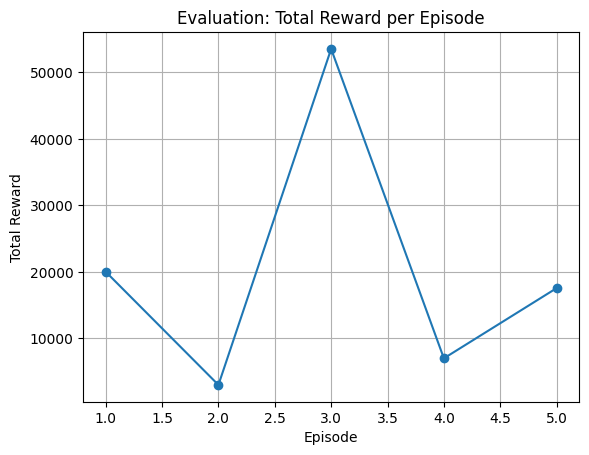

In [29]:
model_filename = "Assignment2_Checkpoint2/Cartpole/dqn_cartpole_episode_5000.pkl"
with open(model_filename, 'rb') as f:
    model_states = pickle.load(f)

# Assuming n_agent is already defined and initialized elsewhere
n_agent.local_qnet.load_state_dict(model_states['local_qnet_state_dict'])
n_agent.optimizer.load_state_dict(model_states['optimizer_state_dict'])
n_agent.time_step = model_states['time_step']

# Initialize the CartPole environment
env = gym.make("CartPole-v1")

# Evaluate the agent for 5 episodes, using only greedy actions
total_rewards = []

for episode in range(5):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        # Convert state to tensor for the model input
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Get action using the greedy policy (no exploration)
        with torch.no_grad():
            action = n_agent.local_qnet(state_tensor).argmax().item()

        # Take action in the environment
        state, reward, done, _, _ = env.step(action)

        total_reward += reward

    total_rewards.append(total_reward)

# Plot total rewards per episode
plt.plot(range(1, 6), total_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Evaluation: Total Reward per Episode')
plt.grid(True)
plt.show()

Episode 100/5000: Epsilon 0.9517, Reward 24.0
Episode 200/5000: Epsilon 0.9053, Reward 22.0
Episode 300/5000: Epsilon 0.8611, Reward 28.0
Episode 400/5000: Epsilon 0.8191, Reward 18.0
Episode 500/5000: Epsilon 0.7791, Reward 13.0
Episode 600/5000: Epsilon 0.7411, Reward 14.0
Episode 700/5000: Epsilon 0.7050, Reward 19.0
Episode 800/5000: Epsilon 0.6706, Reward 56.0
Episode 900/5000: Epsilon 0.6379, Reward 30.0
Episode 1000/5000: Epsilon 0.6068, Reward 49.0
Episode 1100/5000: Epsilon 0.5772, Reward 24.0
Episode 1200/5000: Epsilon 0.5490, Reward 14.0
Episode 1300/5000: Epsilon 0.5222, Reward 100.0
Episode 1400/5000: Epsilon 0.4967, Reward 15.0
Episode 1500/5000: Epsilon 0.4725, Reward 13.0
Episode 1600/5000: Epsilon 0.4495, Reward 12.0
Episode 1700/5000: Epsilon 0.4275, Reward 21.0
Episode 1800/5000: Epsilon 0.4067, Reward 36.0
Episode 1900/5000: Epsilon 0.3868, Reward 14.0
Episode 2000/5000: Epsilon 0.3680, Reward 39.0
Episode 2100/5000: Epsilon 0.3500, Reward 17.0
Episode 2200/5000: Ep

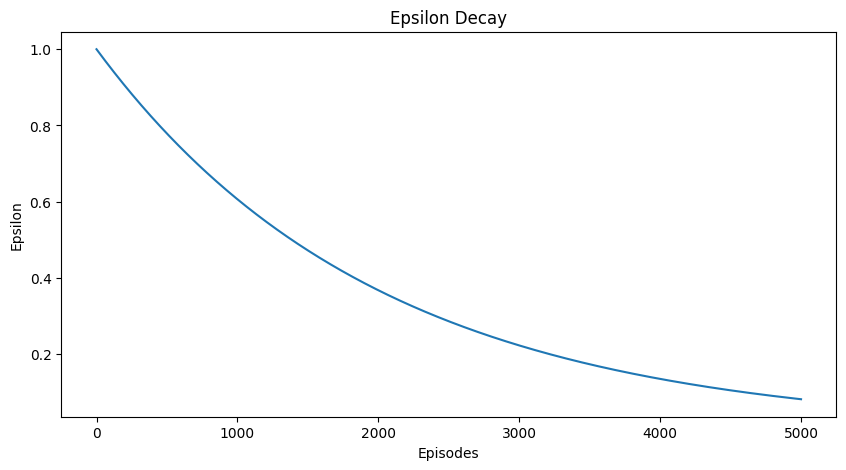

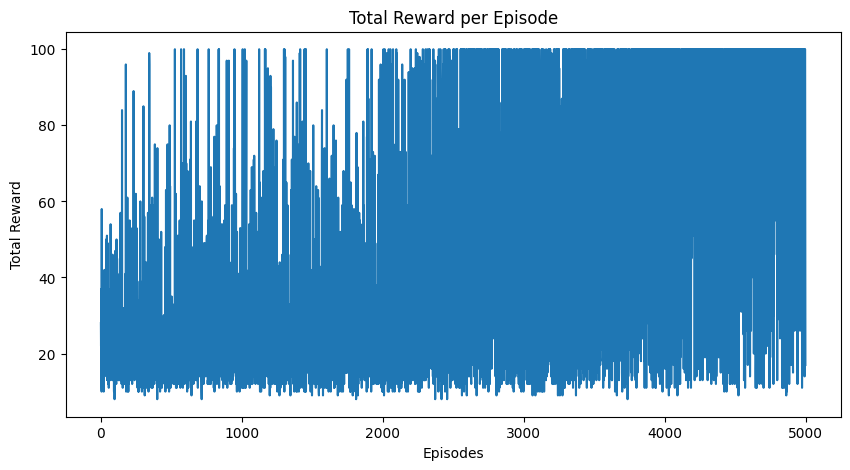

In [31]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("Assignment2_Checkpoint2/Cart", exist_ok=True)

# Track rewards and epsilon values
rewards_per_episode = []
epsilons = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))
    epsilons.append(epsilon)  # Store epsilon for plotting

    total_reward = 0  # Track total episode reward

    for step in range(max_steps_per_episode):
        action = n_agent.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)

        buffer.add(state, action, reward, next_state, done)

        if len(buffer) >= batch_size:
            batch = random.sample(buffer.memory, batch_size)
            n_agent.learn(batch, gamma)

        state = next_state
        total_reward += reward  # Accumulate reward

        if done:
            break

    rewards_per_episode.append(total_reward)  # Store reward

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Epsilon {epsilon:.4f}, Reward {total_reward}")

# Save the model **only once** after training
model_filename = "Assignment2_Checkpoint2/Cart/dqn_Cartpole_final.pkl"
n_agent.save_model(model_filename)
print(f"Model saved at {model_filename}")

# Plot Epsilon Decay
plt.figure(figsize=(10, 5))
plt.plot(epsilons)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.show()

# Plot Total Rewards per Episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


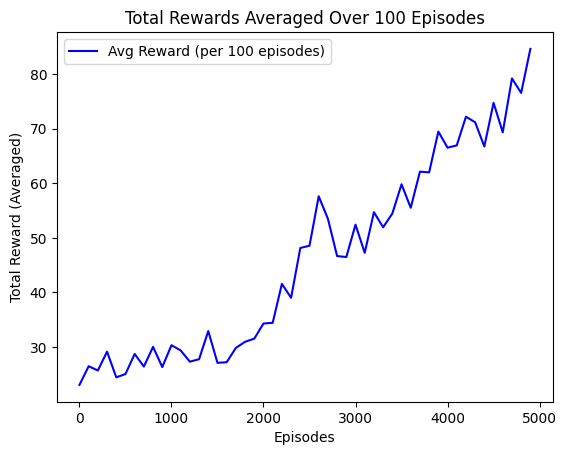

In [38]:
smoothed_rewards = np.mean(np.array(rewards_per_episode).reshape(-1, 100), axis=1)

# Plot the averaged rewards
plt.plot(range(0, len(rewards_per_episode), 100), smoothed_rewards, label="Avg Reward (per 100 episodes)", color='blue')

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Averaged)")
plt.title("Total Rewards Averaged Over 100 Episodes")
plt.legend()
plt.show()